--------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Implementing a simple Gaussian Process Prediction Model using a Weight-based view approach
###### -- I utilized data training points to train a GP model and created a predictive model across -2 to +2 on the x-domain

###### -- Todo: Extend this to be trained using numerous resevoir data
###### --As opposed to just using a guessed parameters (i.e., lengthscale and variance in this model), check out how to optimize the parameters selection to create a good model.

###### PS: All recommended formula for the defined functions would be mathematically typed in the project chapter 3 / 4
---------------------------------------------------------------------------------------------------------------------------------------------------------

##### Created by: Blessing Ekarume
##### Corrected by: Taiwo Adebiyi (Collaborator at the University of Houston)

##### Supervised by: Engr. Ayoola Fadeyi

In [21]:
import numpy as np # numerical computations
import scipy # optimization
import matplotlib.pyplot as plt # plotting
import math # mathematical computations
import random # normally distributed weighted
import time # check computational efficiencies
from pylab import * # plot in Jupyter 
from scipy.stats import norm # another form of weight computations 
#import seaborn as sns # plotting

import GPy # import Gaussian Process (GPy) package for hyperparameters optimizations

X_shape: (200, 1)
Un-normalized f: (200, 1)
Normalized f: (200, 1)

Name : GP regression
Objective : 198.29701135613217
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


{'dataplot': [<matplotlib.collections.PathCollection at 0x282f12dbb10>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x282f12dbc10>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x282f12e1150>]}

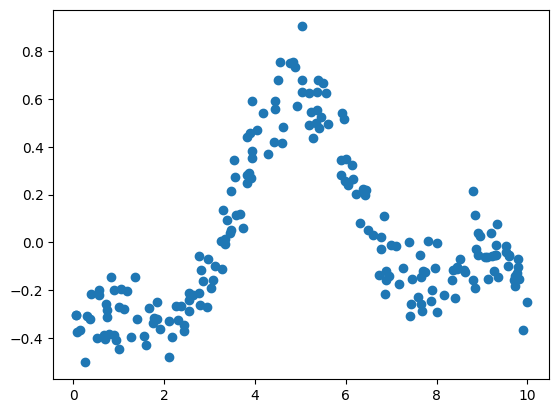

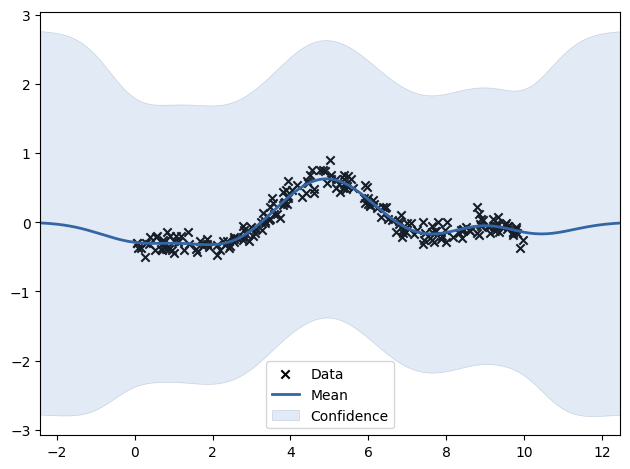

In [22]:
X = np.random.uniform(0, 10, (200, 1))
print(f'X_shape: {X.shape}')
f = np.sin(.3*X) + .3*np.cos(1.3*X)
print(f"Un-normalized f: {f.shape}")
f -= f.mean() # normalize data
print(f"Normalized f: {f.shape}")
Y = f + np.random.normal(0, .1, f.shape) # observations with noise
plt.scatter(X, Y)

m = GPy.models.GPRegression(X, Y) # A simple GP regression model (default kernel is RBF and unit value hyper-parameters)
print(m)
m.plot()

-------------------------------------------------------------------------------------------------------------------------------------------------------
##### Defining a, b, c for eigenvalues and eigenfunctions computations:
-------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
def parameters(sigma, length_scale):
    a = (2 * sigma**2)**(-1)
    b = (2*length_scale**2)**(-1)
    c = sqrt(a**2 + 4*a*b)
    return (a,b,c)

###### Method 2: Use the recursive relations given by Dr. Zhang:

In [24]:
def phi(a, b, c, n, x):
    l = len(x)
    phi = np.zeros((l,n))
    phi[:,0] = (c/a)**(0.25)*exp(-0.5*(c-a)*x**2)
    phi[:,1] = sqrt(2*c)*x*phi[:,0]
    for i in range(2,n):
        phi[:,i] = sqrt(2*c)*x*phi[:,i-1]/sqrt(i) - sqrt((i-1)/(i))*phi[:,i-2]
    return phi

In [25]:
a, b, c = parameters(1, 0.4) # globally defining a, b, c
x = np.arange(-2,2,0.01)
print(phi(a, b, c, 50, x).shape)

(400, 50)


------------------------------------------------------------------------------------------------------------------------------
##### Implementing eigenvalue ($\lambda_n$)
------------------------------------------------------------------------------------------------------------------------------

In [26]:
def lambda_n(a, b, c, n):
    A = (1/2)*a + b + (1/2)*c
    return np.array([sqrt(a/A) * (b/A)**n for n in range(0,n)])

-------------------------------------------------------------------------------------------------------------------------------------------------------
##### Implementing the spectral representation of the GP as a truncated Wiener series ($f_m(x)$):
-------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
def f_m(a, b, c, n, x, w):
    phi_x = phi(a, b, c, n, x)
    w_lam = np.multiply(sqrt(lambda_n(a, b, c, n)), w)
    f = np.dot(w_lam, phi_x.T)
    return f

-------------------------------------------------------------------------------------------------------------------------------------------------------
##### Implementing GP Prior
-------------------------------------------------------------------------------------------------------------------------------------------------------

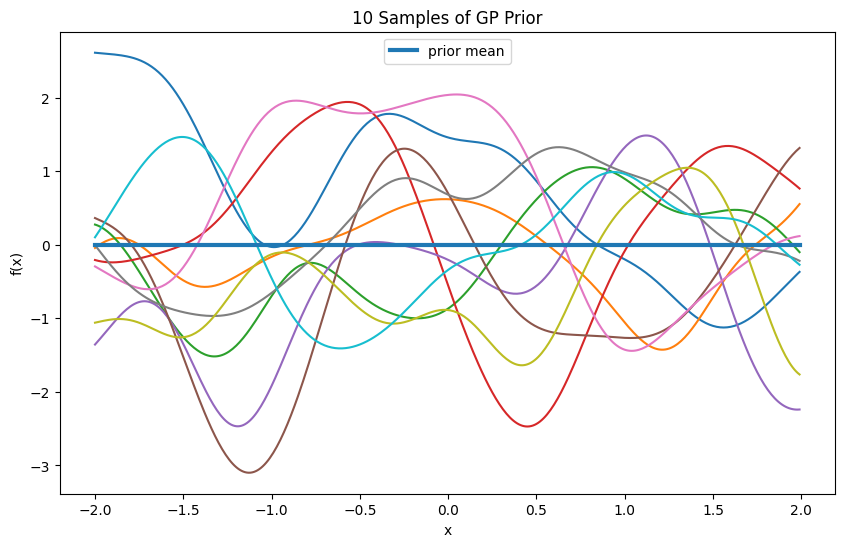

In [28]:
np.random.seed(1) # (seed is needed to get the same results repeatedly)

# Plot Prior Samples
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

# discretizing x-domain
x = np.arange(-2,2,0.01)
n = len(x)

# number of iterations
num_samples = 10
prior_mean = np.zeros(n)
func_x_mean = f_m(a, b, c, n, x, prior_mean)
#func_x_store = np.zeros((num_samples,n))

# sampling num-samples prior GP
for i in range(0, num_samples):
     w = np.random.normal(0,1,50) # generate standard normal w
     # evaluate posterior functions
     func_x = f_m(a, b, c, 50, x, w)
     # posterior samples
     ax.plot(x, func_x)

# plot confidence interval
#ax.fill_between(x, -1.96, 1.96, color = '#a6cce3', alpha = .5, label= 'prior 95% credible interval')
ax.plot(x, func_x_mean, color = '#1f78b4', linewidth = 3, label = 'prior mean')
ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.set_title(f'{num_samples} Samples of GP Prior')
ax.legend(loc="upper center")
plt.savefig(f'prior_sample_{num_samples}.pdf', bbox_inches="tight")

-------------------------------------------------------------------------------------------------------------------------------
##### Implementing the GP Posterior for $f(x)$
-------------------------------------------------------------------------------------------------------------------------------

In [29]:
m = 50 # number of terms
sigma_n = 10**(-3) # noise level

x_j = np.array([-1,0,1]) # x-data
y = (1/sqrt(3), 2/sqrt(3), 3/sqrt(3)) # y-data
n = len(x_j)

phi_x_j= phi(a, b, c, m, x_j)
#print(f"Phi_x_j: {phi_x_j.shape}")

lambda_j = lambda_n(a, b, c, m)
lambda_j_mat = np.diag(lambda_j)
#print(f"lambda_j_mat_shape: {lambda_j_mat.shape}")

H = phi_x_j @ lambda_j_mat**0.5
H = np.float64(H)
print(f"H_shape: {H.shape}")

U, d, Vt = np.linalg.svd(H, full_matrices=False) # Thin SVD
U, D, Vt = U, np.diag(d), Vt
print(f'U: {U.shape}, D: {D.shape}, Vt: {Vt.shape}')

D_1 = np.diag((d / (d**2 + sigma_n**2)))
posterior_mean = Vt.T @ D_1 @ (U.T@y)
#print(f"posterior_mean_shape: {posterior_mean.shape}")

D_2 = np.diag(1 - sqrt(sigma_n**2 / (d**2 + sigma_n**2)))

posterior_mean.shape



H_shape: (3, 50)
U: (3, 3), D: (3, 3), Vt: (3, 50)


(50,)

(400, 50)
(400, 50)
(400,)
mean_shape: (400,)
(400,)
(400,)


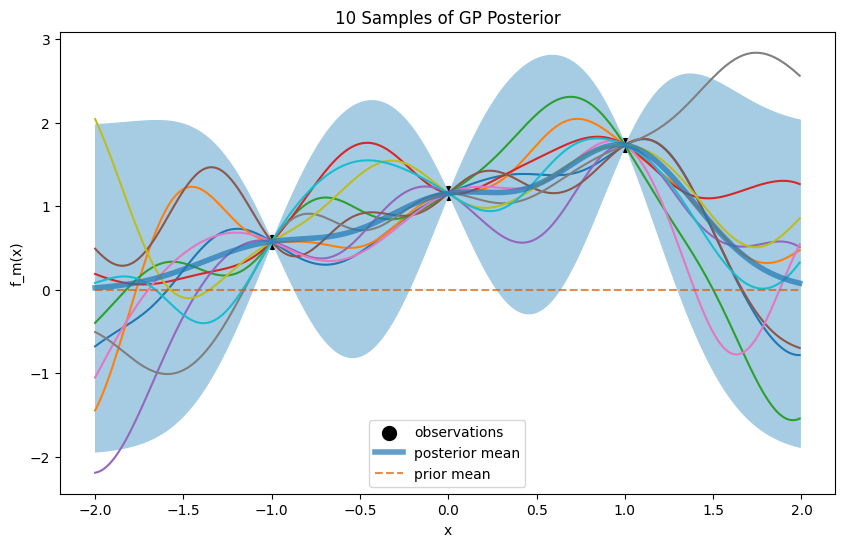

In [30]:
# Plot Posterior Samples
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

# discretizing x-domain
x = np.arange(-2,2,0.01)
n = len(x)

# number of iterations
num_samples = 10

#func_x_mean = np.zeros((n))
func_x_mean = f_m(a, b, c, 50, x, posterior_mean)

HN = phi(a, b, c, m, x) @ lambda_j_mat**0.5
print(HN.shape)
HNR = HN - (HN @ Vt.T) @ (D_2 @ Vt)
print(HNR.shape)
stdfp = np.linalg.norm(HNR, ord=2, axis=1, keepdims=False)
print(stdfp.shape)

# sampling num-samples prior GP
for i in range(0,num_samples):
    z = np.random.normal(0,1,50)
    Rz = z - (Vt.T @ D_2 @ (Vt@z))
    sample_posterior_w = posterior_mean + Rz # important
    func_x = f_m(a, b, c, 50, x, sample_posterior_w) # main function
    ax.plot(x, func_x)

# plot datapoints
ax.scatter(x_j, y, color = 'black', linewidths=5, label='observations')

# plot posterior mean
ax.plot(x, func_x_mean, color = '#1f78b4', linewidth = 4, alpha = .7, label='posterior mean')

# plot the prior mean to see if the posterior mean converges to the prior mean at far points
ax.plot(x, np.zeros(n), color = '#d95f02', linestyle="--", linewidth = 1.5, alpha = .7, label='prior mean')

# plot confidence interval
print(f'mean_shape: {func_x_mean.shape}')
ci_lower = func_x_mean - 1.96 * (stdfp)
ci_upper = func_x_mean + 1.96 * (stdfp)
print(ci_lower.shape)
print(ci_upper.shape)

ax.fill_between(x, ci_lower, ci_upper, color = '#a6cce3', alpha = 1) #label = 'poster 95% credible interval'

ax.set_xlabel('x')
ax.set_ylabel('f_m(x)')
ax.set_title(f'{num_samples} Samples of GP Posterior')
ax.legend(loc="lower center")
plt.savefig(f'posterior_samples_{num_samples}.pdf', bbox_inches="tight")